#Deraining from Images

## Initial Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import shutil

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available. Using device: {device}")
else:
    device = torch.device("cpu")
    print(f"GPU not available. Using device: {device}")

# --- Configuration ---
ZIP_FILE_PATH = 'archive.zip'
DATA_DIR = 'dataset'
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-4

RAINY_IMG_DIR = os.path.join(DATA_DIR, 'Rain100L', 'input')
CLEAN_IMG_DIR = os.path.join(DATA_DIR, 'Rain100L', 'target')


GPU is available. Using device: cuda


## Unzip data

In [3]:
def unzip_and_prepare_dataset(zip_path, extract_to):
    """Unzips the dataset from a local zip file."""
    # Clean up previous extractions if they exist
    if os.path.exists(extract_to):
        print(f"Removing existing directory: {extract_to}")
        shutil.rmtree(extract_to)

    # Check if the zip file exists
    if not os.path.exists(zip_path):
        print(f"Error: Zip file not found at '{zip_path}'")
        print("Please make sure you have uploaded 'archive.zip' to your Colab session.")
        return False

    print(f"Found '{zip_path}'. Extracting to '{extract_to}'...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete.")
        return True
    except zipfile.BadZipFile:
        print(f"Error: '{zip_path}' is not a valid zip file.")
        return False
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")
        return False

# Execute the unzipping process
if unzip_and_prepare_dataset(ZIP_FILE_PATH, DATA_DIR):
    # Verify that the final directories exist
    if os.path.exists(RAINY_IMG_DIR) and os.path.exists(CLEAN_IMG_DIR):
        print("\nVerification successful!")
        print(f"Rainy images found at: {RAINY_IMG_DIR}")
        print(f"Clean images found at: {CLEAN_IMG_DIR}")
    else:
        print("\nError: Could not find 'input' and 'target' directories after extraction.")
        print("Please check the structure of your 'archive.zip' file.")


Found 'archive.zip'. Extracting to 'dataset'...
Extraction complete.

Verification successful!
Rainy images found at: dataset/Rain100L/input
Clean images found at: dataset/Rain100L/target


## Creating custom dataset

In [4]:
class RainDataset(Dataset):
    """
    Custom Dataset for loading pairs of rainy (input) and clean (target) images.
    """
    def __init__(self, rainy_dir, clean_dir, transform=None):
        self.rainy_dir = rainy_dir
        self.clean_dir = clean_dir
        self.transform = transform

        # Get sorted lists of image filenames to ensure pairs match
        self.rainy_images = sorted(os.listdir(rainy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))

    def __len__(self):
        # The number of samples is the number of rainy images
        return len(self.rainy_images)

    def __getitem__(self, idx):
        # Construct file paths for the corresponding pair
        rainy_img_name = self.rainy_images[idx]
        clean_img_name = self.clean_images[idx] # Assumes direct correspondence

        rainy_img_path = os.path.join(self.rainy_dir, rainy_img_name)
        clean_img_path = os.path.join(self.clean_dir, clean_img_name)

        # Open images
        rainy_image = Image.open(rainy_img_path).convert("RGB")
        clean_image = Image.open(clean_img_path).convert("RGB")

        # Apply transformations if any
        if self.transform:
            rainy_image = self.transform(rainy_image)
            clean_image = self.transform(clean_image)

        return rainy_image, clean_image

# Define image transformations
transformations = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to a tensor and scales values to [0, 1]
    transforms.Resize((256, 256), antialias=True) # Resize for uniform batching
])

# Create the full dataset
full_dataset = RainDataset(
    rainy_dir=RAINY_IMG_DIR,
    clean_dir=CLEAN_IMG_DIR,
    transform=transformations
)

# Split dataset into training and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDataset prepared successfully.")
print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



Dataset prepared successfully.
Total samples: 100
Training samples: 90
Validation samples: 10


## Defining U-net

In [5]:
class DoubleConv(nn.Module):
    """A block of two convolutional layers, each followed by BatchNorm and ReLU."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    U-Net architecture for image-to-image translation.
    """
    def __init__(self, n_channels=3, n_classes=3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (Down-sampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # Decoder (Up-sampling path)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256) # Input is 256 (from up) + 256 (from skip)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128) # Input is 128 (from up) + 128 (from skip)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64) # Input is 64 (from up) + 64 (from skip)

        # Output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.final_activation = nn.Sigmoid() # To ensure output pixel values are in [0, 1]

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # Decoder with skip connections
        u1 = self.up1(x4)
        merge1 = torch.cat([x3, u1], dim=1) # Concatenate skip connection
        c1 = self.conv1(merge1)

        u2 = self.up2(c1)
        merge2 = torch.cat([x2, u2], dim=1)
        c2 = self.conv2(merge2)

        u3 = self.up3(c2)
        merge3 = torch.cat([x1, u3], dim=1)
        c3 = self.conv3(merge3)

        # Final output
        logits = self.outc(c3)
        return self.final_activation(logits)

# Instantiate the model and move it to the configured device
model = UNet(n_channels=3, n_classes=3).to(device)
print("\nU-Net model created successfully and moved to device.")
# print(model) # Uncomment to see the full model architecture



U-Net model created successfully and moved to device.


## Training

In [6]:
# --- Loss Function and Optimizer ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting model training...")
print("-" * 30)

# --- Training Loop ---
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (rainy_imgs, clean_imgs) in enumerate(train_loader):
        # Move tensors to the configured device
        rainy_imgs = rainy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # --- Forward pass ---
        outputs = model(rainy_imgs)
        loss = criterion(outputs, clean_imgs)

        # --- Backward pass and optimize ---
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rainy_imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for rainy_imgs, clean_imgs in val_loader:
            rainy_imgs = rainy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            outputs = model(rainy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item() * rainy_imgs.size(0)

    val_loss /= len(val_dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_loss:.6f} | Val Loss: {val_loss:.6f}")

print("\nFinished Training.")
# You can save the trained model's weights for later use
torch.save(model.state_dict(), 'derain_model_final.pth')
print("Model state saved to derain_model_final.pth")



Starting model training...
------------------------------
Epoch 1/50 | Train Loss: 0.026777 | Val Loss: 0.042217
Epoch 2/50 | Train Loss: 0.012171 | Val Loss: 0.013003
Epoch 3/50 | Train Loss: 0.009243 | Val Loss: 0.006502
Epoch 4/50 | Train Loss: 0.009656 | Val Loss: 0.004297
Epoch 5/50 | Train Loss: 0.007535 | Val Loss: 0.005819
Epoch 6/50 | Train Loss: 0.006746 | Val Loss: 0.003389
Epoch 7/50 | Train Loss: 0.006782 | Val Loss: 0.003315
Epoch 8/50 | Train Loss: 0.007132 | Val Loss: 0.003248
Epoch 9/50 | Train Loss: 0.006634 | Val Loss: 0.003453
Epoch 10/50 | Train Loss: 0.006929 | Val Loss: 0.005681
Epoch 11/50 | Train Loss: 0.006241 | Val Loss: 0.003538
Epoch 12/50 | Train Loss: 0.006465 | Val Loss: 0.002917
Epoch 13/50 | Train Loss: 0.006030 | Val Loss: 0.003118
Epoch 14/50 | Train Loss: 0.005984 | Val Loss: 0.002767
Epoch 15/50 | Train Loss: 0.005163 | Val Loss: 0.003525
Epoch 16/50 | Train Loss: 0.004812 | Val Loss: 0.003820
Epoch 17/50 | Train Loss: 0.006327 | Val Loss: 0.00343

## Evaluating and visualizing


Visualizing model performance on unseen validation data...


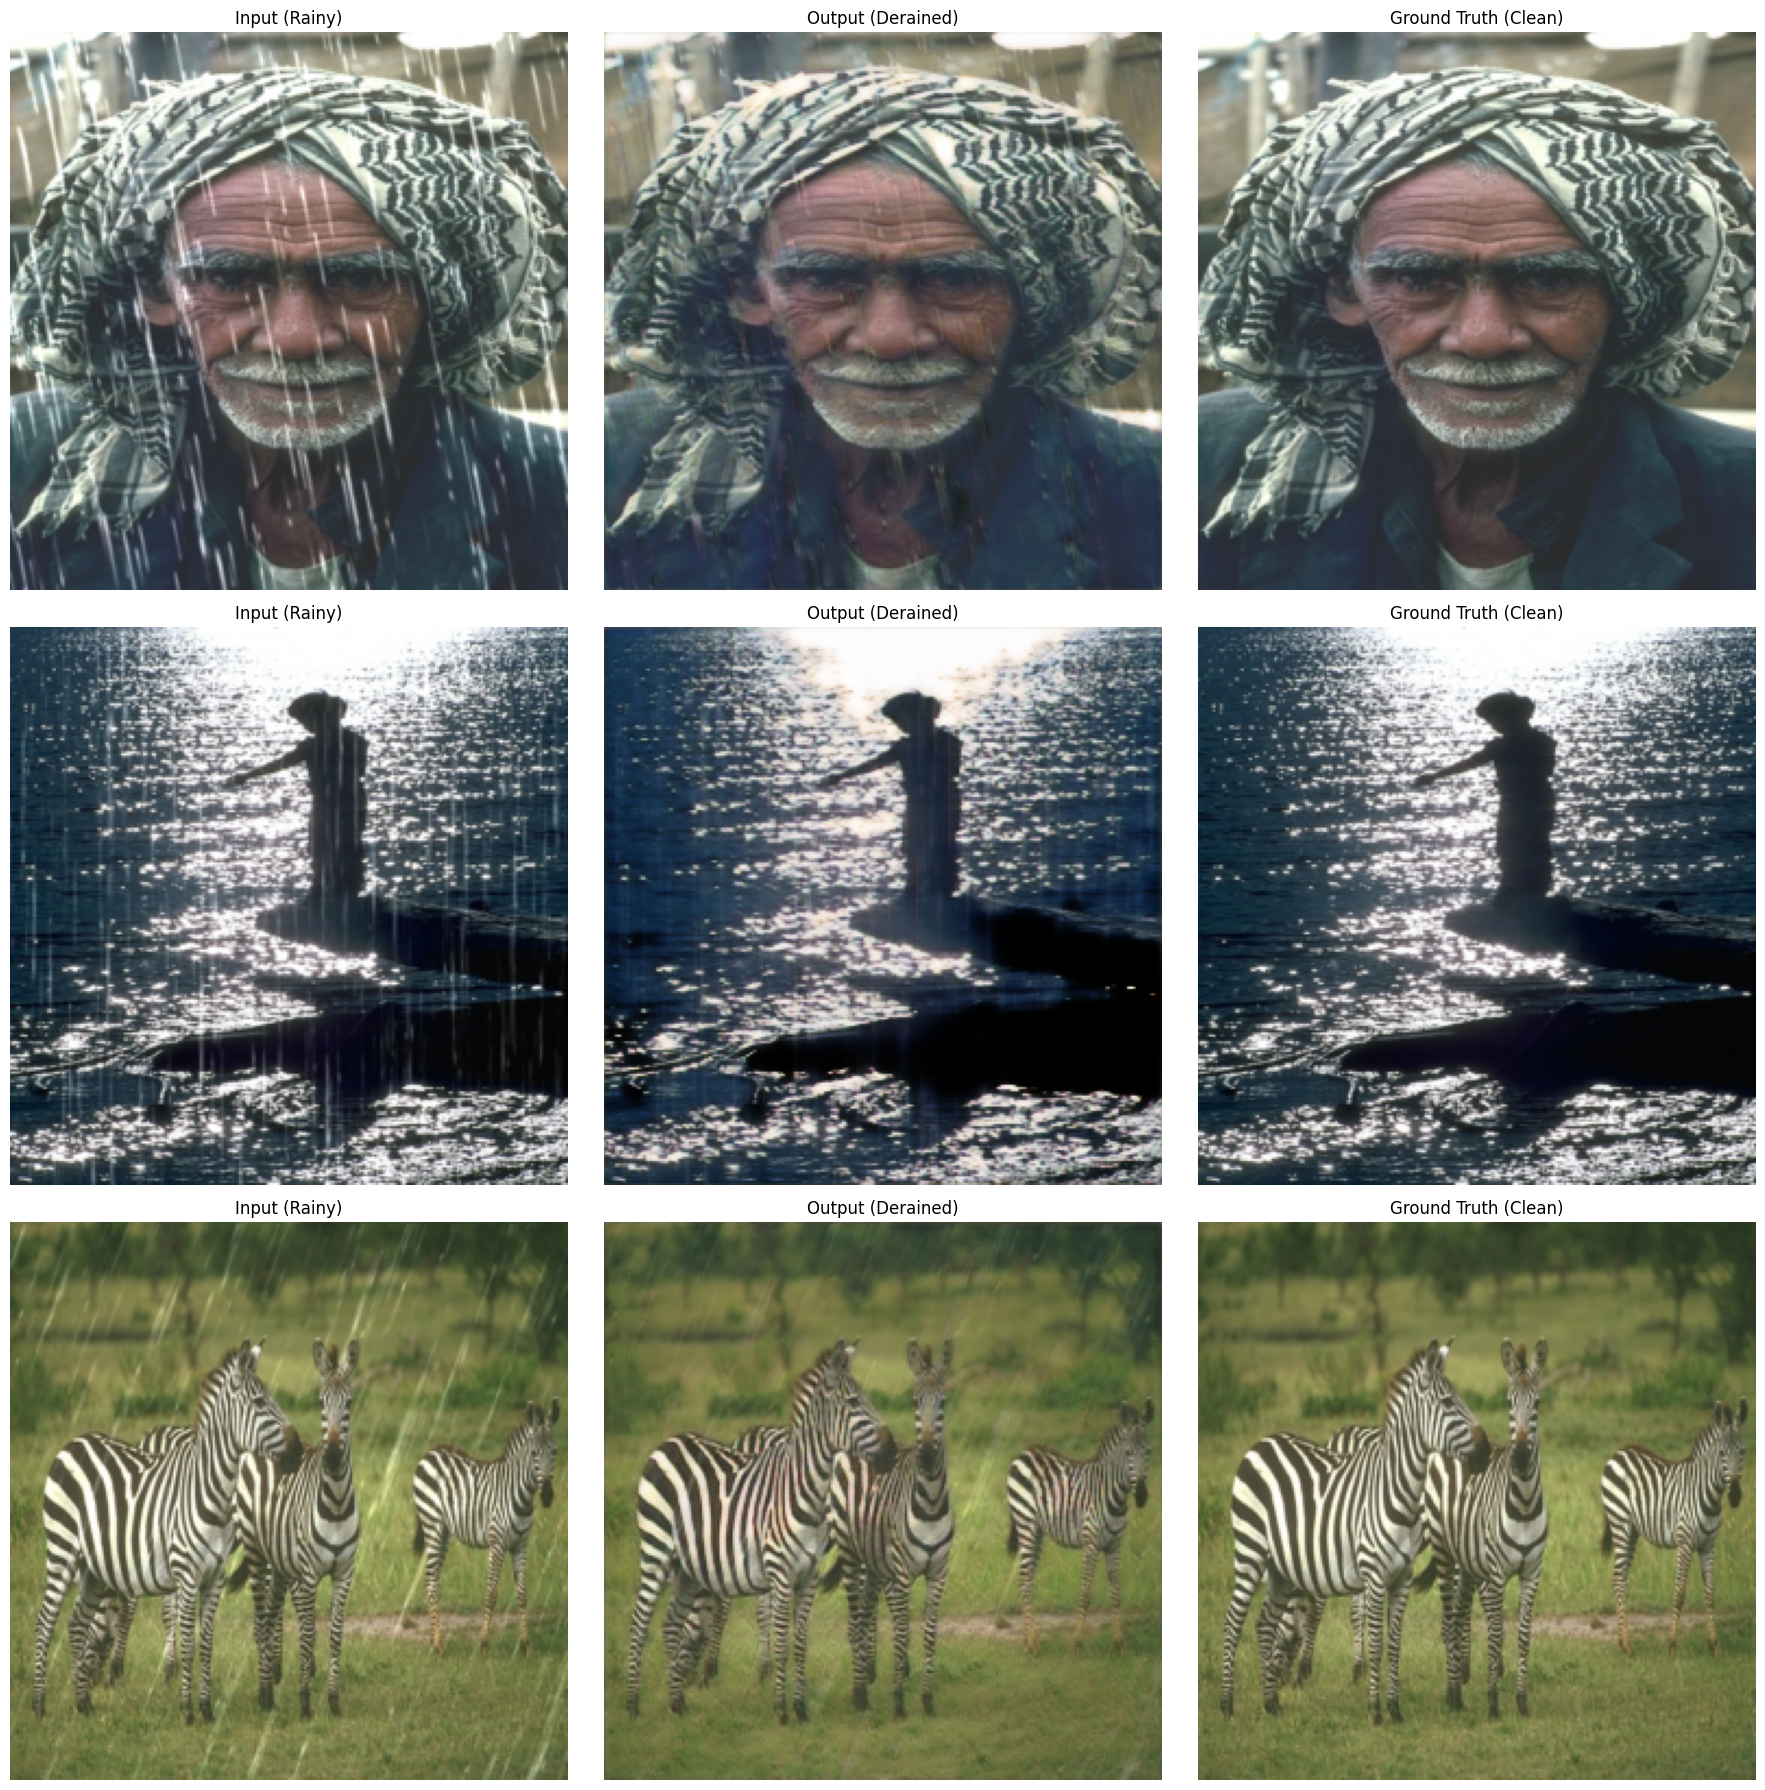

In [7]:
def visualize_results(model, data_loader, num_images=5):
    """
    Displays a comparison of rainy, derained, and clean images from a data loader.
    """
    model.eval()  # Set the model to evaluation mode

    # Get a single batch of data
    try:
        rainy_batch, clean_batch = next(iter(data_loader))
    except StopIteration:
        print("Data loader is empty. Cannot visualize results.")
        return

    with torch.no_grad():
        # Move data to the device and get model output
        rainy_batch = rainy_batch.to(device)
        derained_batch = model(rainy_batch)

    # Move tensors back to CPU for plotting with Matplotlib
    rainy_batch = rainy_batch.cpu()
    derained_batch = derained_batch.cpu()
    clean_batch = clean_batch.cpu()

    # Determine the number of images to show from the batch
    num_to_show = min(num_images, len(rainy_batch))

    plt.figure(figsize=(18, num_to_show * 6))
    for i in range(num_to_show):
        # --- Rainy Image (Input) ---
        ax = plt.subplot(num_to_show, 3, i * 3 + 1)
        # Permute tensor from (C, H, W) to (H, W, C) for displaying
        rainy_img = rainy_batch[i].permute(1, 2, 0).numpy()
        plt.imshow(rainy_img)
        ax.set_title("Input (Rainy)")
        ax.axis("off")

        # --- Derained Image (Model Output) ---
        ax = plt.subplot(num_to_show, 3, i * 3 + 2)
        derained_img = derained_batch[i].permute(1, 2, 0).numpy()
        plt.imshow(derained_img)
        ax.set_title("Output (Derained)")
        ax.axis("off")

        # --- Clean Image (Ground Truth) ---
        ax = plt.subplot(num_to_show, 3, i * 3 + 3)
        clean_img = clean_batch[i].permute(1, 2, 0).numpy()
        plt.imshow(clean_img)
        ax.set_title("Ground Truth (Clean)")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize results using the validation loader
print("\nVisualizing model performance on unseen validation data...")
visualize_results(model, val_loader, num_images=3)


In [8]:
import numpy as np
from scipy.ndimage import gaussian_filter

# PSNR function
def calculate_psnr(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    mse = np.mean((pred - gt) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1.0 / mse)

# SSIM function (basic implementation for RGB images)
def calculate_ssim(pred, gt, data_range=1.0, sigma=1.5):
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)  # Convert to HWC
    gt = gt.cpu().detach().numpy().transpose(1, 2, 0)  # Convert to HWC
    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2

    mu1 = gaussian_filter(pred, sigma)
    mu2 = gaussian_filter(gt, sigma)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = gaussian_filter(pred ** 2, sigma) - mu1_sq
    sigma2_sq = gaussian_filter(gt ** 2, sigma) - mu2_sq
    sigma12 = gaussian_filter(pred * gt, sigma) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return np.mean(ssim_map)

# Load the trained model
model.load_state_dict(torch.load('derain_model_final.pth'))
model.eval()

# Evaluate on validation set
psnr_values = []
ssim_values = []
with torch.no_grad():
    for rainy_imgs, clean_imgs in val_loader:
        rainy_imgs = rainy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)
        # Generate derained images
        derained_imgs = model(rainy_imgs)
        # Compute metrics for each image in the batch
        for i in range(derained_imgs.size(0)):
            psnr = calculate_psnr(derained_imgs[i], clean_imgs[i])
            ssim = calculate_ssim(derained_imgs[i], clean_imgs[i])
            psnr_values.append(psnr)
            ssim_values.append(ssim)

# Calculate average metrics
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print(f"Average PSNR on validation set: {avg_psnr:.2f} dB")
print(f"Average SSIM on validation set: {avg_ssim:.4f}")

Average PSNR on validation set: 26.97 dB
Average SSIM on validation set: 0.9003


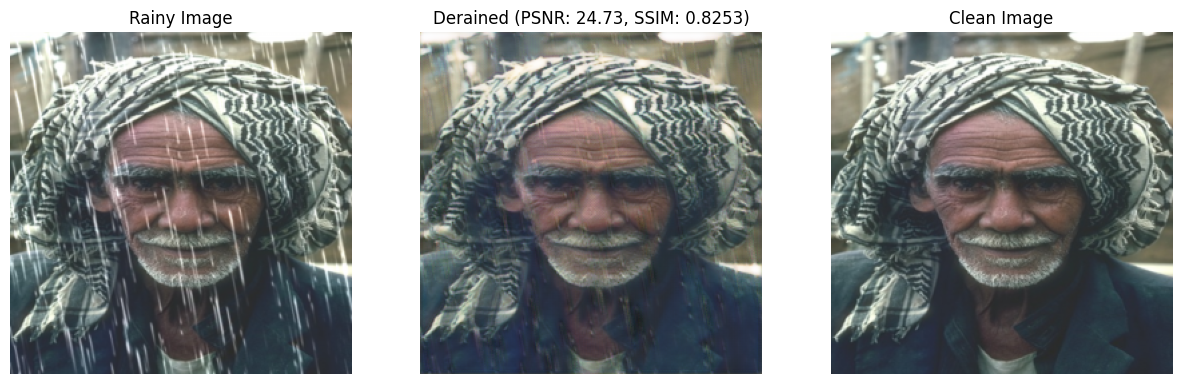

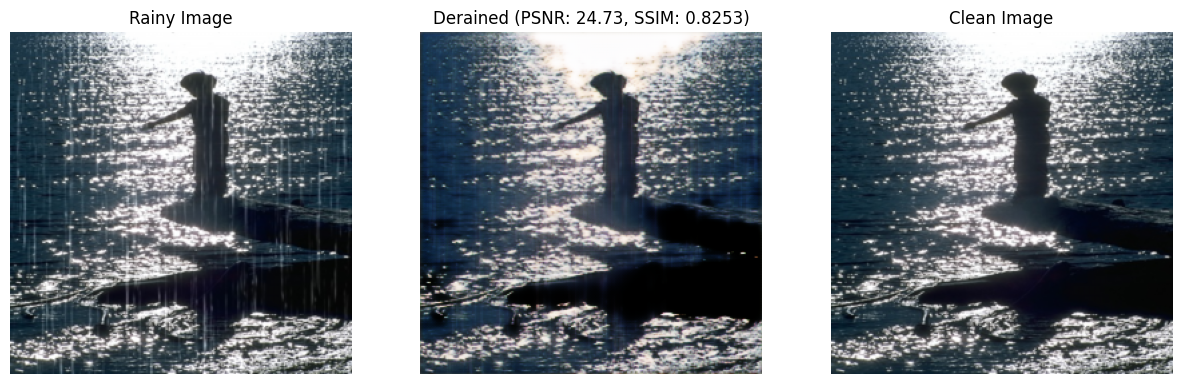

Average MAE on validation set: 0.0324
Average PSNR on validation set: 26.97 dB
Average SSIM on validation set: 0.9003


In [10]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# MAE function
def calculate_mae(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    return np.mean(np.abs(pred - gt))

# PSNR function
def calculate_psnr(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    mse = np.mean((pred - gt) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1.0 / mse)

# SSIM function
def calculate_ssim(pred, gt, data_range=1.0, sigma=1.5):
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    gt = gt.cpu().detach().numpy().transpose(1, 2, 0)
    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2
    mu1 = gaussian_filter(pred, sigma)
    mu2 = gaussian_filter(gt, sigma)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = gaussian_filter(pred ** 2, sigma) - mu1_sq
    sigma2_sq = gaussian_filter(gt ** 2, sigma) - mu2_sq
    sigma12 = gaussian_filter(pred * gt, sigma) - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return np.mean(ssim_map)

# Load the trained model
model.load_state_dict(torch.load('derain_model_final.pth'))
model.eval()

# Evaluate on validation set with multiple metrics
mae_values = []
psnr_values = []
ssim_values = []
with torch.no_grad():
    for batch_idx, (rainy_imgs, clean_imgs) in enumerate(val_loader):
        rainy_imgs = rainy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)
        derained_imgs = model(rainy_imgs)

        # Compute metrics for each image
        for i in range(derained_imgs.size(0)):
            mae = calculate_mae(derained_imgs[i], clean_imgs[i])
            psnr = calculate_psnr(derained_imgs[i], clean_imgs[i])
            ssim = calculate_ssim(derained_imgs[i], clean_imgs[i])
            mae_values.append(mae)
            psnr_values.append(psnr)
            ssim_values.append(ssim)

        # Visualize first two images of the first batch
        if batch_idx == 0:
            for i in range(min(2, derained_imgs.size(0))):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(rainy_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title("Rainy Image")
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(derained_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title(f"Derained (PSNR: {psnr_values[-1]:.2f}, SSIM: {ssim_values[-1]:.4f})")
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.imshow(clean_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title("Clean Image")
                plt.axis('off')
                plt.show()

# Calculate and print average metrics
avg_mae = np.mean(mae_values)
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print(f"Average MAE on validation set: {avg_mae:.4f}")
print(f"Average PSNR on validation set: {avg_psnr:.2f} dB")
print(f"Average SSIM on validation set: {avg_ssim:.4f}")

In [11]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
import torch

# Metric functions
def calculate_mae(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    return np.mean(np.abs(pred - gt))

def calculate_psnr(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    mse = np.mean((pred - gt) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(1.0 / mse)

def calculate_ssim(pred, gt, data_range=1.0, sigma=1.5):
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    gt = gt.cpu().detach().numpy().transpose(1, 2, 0)
    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2
    mu1 = gaussian_filter(pred, sigma)
    mu2 = gaussian_filter(gt, sigma)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = gaussian_filter(pred ** 2, sigma) - mu1_sq
    sigma2_sq = gaussian_filter(gt ** 2, sigma) - mu2_sq
    sigma12 = gaussian_filter(pred * gt, sigma) - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return np.mean(ssim_map)

def calculate_nmse(pred, gt):
    pred = pred.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    mse = np.mean((pred - gt) ** 2)
    gt_energy = np.mean(gt ** 2)
    return mse / gt_energy if gt_energy > 0 else float('inf')

# Baseline metrics (rainy vs clean)
baseline_mae = []
baseline_psnr = []
baseline_ssim = []
with torch.no_grad():
    for rainy_imgs, clean_imgs in val_loader:
        for i in range(rainy_imgs.size(0)):
            mae = calculate_mae(rainy_imgs[i], clean_imgs[i])
            psnr = calculate_psnr(rainy_imgs[i], clean_imgs[i])
            ssim = calculate_ssim(rainy_imgs[i], clean_imgs[i])
            baseline_mae.append(mae)
            baseline_psnr.append(psnr)
            baseline_ssim.append(ssim)
print(f"Baseline MAE (rainy vs clean): {np.mean(baseline_mae):.4f}")
print(f"Baseline PSNR (rainy vs clean): {np.mean(baseline_psnr):.2f} dB")
print(f"Baseline SSIM (rainy vs clean): {np.mean(baseline_ssim):.4f}")

# Load and evaluate model
model.load_state_dict(torch.load('derain_model_final.pth'))
model.eval()

os.makedirs('validation_samples', exist_ok=True)
mae_values = []
psnr_values = []
ssim_values = []
nmse_values = []
with torch.no_grad():
    for batch_idx, (rainy_imgs, clean_imgs) in enumerate(val_loader):
        rainy_imgs = rainy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)
        derained_imgs = model(rainy_imgs)
        for i in range(derained_imgs.size(0)):
            mae = calculate_mae(derained_imgs[i], clean_imgs[i])
            psnr = calculate_psnr(derained_imgs[i], clean_imgs[i])
            ssim = calculate_ssim(derained_imgs[i], clean_imgs[i])
            nmse = calculate_nmse(derained_imgs[i], clean_imgs[i])
            mae_values.append(mae)
            psnr_values.append(psnr)
            ssim_values.append(ssim)
            nmse_values.append(nmse)
        if batch_idx == 0:
            for i in range(min(2, derained_imgs.size(0))):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(rainy_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title("Rainy Image")
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(derained_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title(f"Derained (PSNR: {psnr_values[-1]:.2f}, SSIM: {ssim_values[-1]:.4f})")
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.imshow(clean_imgs[i].cpu().permute(1, 2, 0).numpy())
                plt.title("Clean Image")
                plt.axis('off')
                plt.savefig(f'validation_samples/sample_{batch_idx}_{i}.png')
                plt.close()

# Print average metrics
print(f"Average MAE on validation set: {np.mean(mae_values):.4f}")
print(f"Average PSNR on validation set: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM on validation set: {np.mean(ssim_values):.4f}")
print(f"Average NMSE on validation set: {np.mean(nmse_values):.4f}")

Baseline MAE (rainy vs clean): 0.0251
Baseline PSNR (rainy vs clean): 24.84 dB
Baseline SSIM (rainy vs clean): 0.8729
Average MAE on validation set: 0.0324
Average PSNR on validation set: 26.97 dB
Average SSIM on validation set: 0.9003
Average NMSE on validation set: 0.0090
